<a href="https://colab.research.google.com/github/hrishikeshmane/Auto_ppt/blob/master/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [25]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [27]:
batch_size = 64
img_height = 224
img_width = 224
IMG_SIZE = 224
NUM_CLASSES = 5

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [33]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [34]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [38]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(
    optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"]
)

In [40]:
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3,
  verbose =2
)

Epoch 1/3
46/46 - 37s - loss: 1.5591 - accuracy: 0.3392 - val_loss: 1.7631 - val_accuracy: 0.1417
Epoch 2/3
46/46 - 34s - loss: 1.6354 - accuracy: 0.2629 - val_loss: 1.6446 - val_accuracy: 0.2602
Epoch 3/3
46/46 - 34s - loss: 1.6196 - accuracy: 0.2844 - val_loss: 1.7591 - val_accuracy: 0.1458


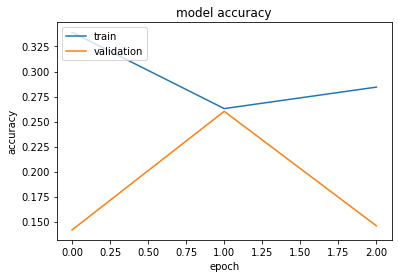

In [42]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)